In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.cosmology import Planck18
#from scipy.special import erf, erfc,erfcx
import scipy
import emcee
import corner
from astropy.table import Table
from astropy.io import fits
import fitsio
import matplotlib as mpl
from multiprocessing import Pool
import torch
from torch.special import erfcx 


In [2]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_gg']) | np.isinf(k['k_gg']) | np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [3]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.1) & (d['Z'] < 2.8))[0]
apr_mag_g = d['APP_MAG_G'][SEL][~indice]
apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z = d['Z'][SEL][~indice]
TARGETID = d['TARGETID'][SEL][~indice]
d = Planck18.distmod(z).value

In [4]:
m_lim = 22.5
indice = (apr_mag_g < m_lim) & (apr_mag_r < m_lim)
apr_mag_g = apr_mag_g[indice]
apr_mag_g_err = apr_mag_g_err[indice]
d = d[indice]
k_gg = k_gg[indice]

apr_mag_r = apr_mag_r[indice]
apr_mag_r_err = apr_mag_r_err[indice]
k_rr = k_rr[indice]

In [5]:
def log_likelihood(params, apr_mag1, magerr1, k1, apr_mag2, magerr2, k2,d, m_lim):
    sigma_I1,M_X1 = params[:2]
    sigma_I2, M_X2,a = params[2:5]
    m_real1 = params[5:apr_mag1.shape[0]+5]
    m_real2 = params[apr_mag1.shape[0]+5:2*apr_mag1.shape[0]+5]
    A_x = params[2*apr_mag1.shape[0]+5:3*apr_mag1.shape[0]+5]

    #term1 = -torch.log(2 * torch.pi * magerr1 * sigma_I1)  # Avoid division by zero
    term1 = -torch.log(magerr1)-torch.log(sigma_I1)
    term2 = -0.5 * ((apr_mag1 - m_real1) / magerr1) ** 2
    term3 = -0.5 * ((m_real1 - d - k1 - M_X1 + A_x) / sigma_I1) ** 2
    #term4 = -torch.log(torch.tensor(0.5)) - torch.log(torch.erfc((apr_mag1 - m_lim) / (torch.sqrt(torch.tensor(2.0)) * magerr1)))
    
    #term5 = -torch.log(2 * torch.pi * magerr2 * sigma_I2)  # Avoid division by zero
    term5 =  -torch.log(magerr2)-torch.log(sigma_I2)
    term6 = -0.5 * ((apr_mag2 - m_real2) / magerr2) ** 2
    term7 = -0.5 * ((m_real2 - d - k2 - M_X2 + A_x) / sigma_I2) ** 2
    #term8 = -torch.log(torch.tensor(0.5)) - torch.log(torch.erfc((apr_mag2 - m_lim) / (torch.sqrt(torch.tensor(2.0)) * magerr2)))
    
    #print(torch.sum(term3))
    total_log_likelihood = torch.sum(term1 + term2 + term3  + term5 + term6 + term7)
    return total_log_likelihood

In [6]:
apr_mag_g = apr_mag_g.astype(np.float32)
apr_mag_g_err = apr_mag_g_err.astype(np.float32)
k_gg = k_gg.astype(np.float32)

apr_mag_r = apr_mag_r.astype(np.float32)
apr_mag_r_err = apr_mag_r_err.astype(np.float32)
k_rr = k_rr.astype(np.float32)

d = d.astype(np.float32)

# Convert your data to PyTorch tensors
apr_mag_g_tensor = torch.from_numpy(apr_mag_g)
apr_mag_g_err_tensor = torch.from_numpy(apr_mag_g_err)
k_gg_tensor = torch.from_numpy(k_gg)

apr_mag_r_tensor = torch.from_numpy(apr_mag_r)
apr_mag_r_err_tensor = torch.from_numpy(apr_mag_r_err)
k_rr_tensor = torch.from_numpy(k_rr)

d_tensor = torch.from_numpy(d)

In [7]:
params = torch.zeros(3*apr_mag_g_tensor.shape[0]+5, requires_grad=False)
params[0] = 1
params[1] = -25
params[2] = 1
params[3] = -25
params[2*apr_mag_g_tensor.shape[0]+5:3*apr_mag_g_tensor.shape[0]+5] = 0

# Adjust requires_grad to True afterwards
params.requires_grad_(True)

optimizer = torch.optim.AdamW([params], lr=0.003)
epochs = []
Losses = []
param0_values = []  # List to track params[0] values
param1_values = []  # List to track params[1] values
param2_values = []
param3_values = []  # List to track params[0] values
param4_values = []  # List to track params[1] values
param5_values = []
A1 = []
# Optimization loop
for epoch in range(150000):  # Number of epochs, adjust as needed
    optimizer.zero_grad()
    loss = -log_likelihood(params, apr_mag_g_tensor, apr_mag_g_err_tensor, k_gg_tensor,apr_mag_r_tensor,
                           apr_mag_r_err_tensor, k_rr_tensor,d_tensor,22.5 )
    loss.backward()
    optimizer.step()

    subset_start_g = 2*apr_mag_g_tensor.shape[0]+5
    subset_end_g = 3*apr_mag_g_tensor.shape[0]+5
    subset_mean_g = params[subset_start_g:subset_end_g].mean()
    params.data[subset_start_g:subset_end_g] -= subset_mean_g
    
    with torch.no_grad():
        params[0].clamp_(0.01,2)#intrinsic dispersion
        params[1].clamp_(-30,-20)#average absolute magnitude
        params[2].clamp_(0.01,2)#intrinsic dispersion
        params[3].clamp_(-30,-20)#average absolute magnitude
        #params[4].clamp_(-1,1)
        #params[subset_start_g:subset_end_g].clamp_(-0.5,0.5)
    epochs.append(epoch)
    Losses.append(loss.item())
    param0_values.append(params[0].item())
    param1_values.append(params[1].item())
    param2_values.append(params[2].item())
    param3_values.append(params[3].item())
    param4_values.append(params[4].item())
    param5_values.append(params[5].item())
    A1.append(params[subset_start_g].item())
    if epoch % 100 == 0:  # Print loss every 100 epochs
        print(f"Epoch {epoch}, Loss: {loss.item()}, Param0: {params[0].item()}, Param1: {params[1].item()},Params2:{params[2].item()},Params3:{params[3].item()},Params4:{params[4].item()},Params5:{params[5].item()},A1:{params[subset_start_g].item()}")

Epoch 0, Loss: 1309241245696.0, Param0: 1.0029699802398682, Param1: -25.00225067138672,Params2:1.0029699802398682,Params3:-25.00225067138672,Params4:0.0,Params5:0.003000000026077032,A1:1.1641532182693481e-09
Epoch 100, Loss: 1269599043584.0, Param0: 1.2594680786132812, Param1: -25.20074462890625,Params2:1.2594655752182007,Params3:-25.200740814208984,Params4:0.0,Params5:0.30181318521499634,A1:-1.7161713913083076e-05
Epoch 200, Loss: 1230981431296.0, Param0: 1.445864200592041, Param1: -25.35214614868164,Params2:1.4458553791046143,Params3:-25.35213851928711,Params4:0.0,Params5:0.5977444648742676,A1:-7.468997500836849e-05
Epoch 300, Loss: 1193356951552.0, Param0: 1.5953919887542725, Param1: -25.47782325744629,Params2:1.595373511314392,Params3:-25.477811813354492,Params4:0.0,Params5:0.890811562538147,A1:-0.00016664655413478613
Epoch 400, Loss: 1156695064576.0, Param0: 1.7219184637069702, Param1: -25.58710289001465,Params2:1.7218881845474243,Params3:-25.58708381652832,Params4:0.0,Params5:1.1

KeyboardInterrupt: 

In [ ]:
'''
# Initialize parameters, ensuring they require gradients
params1 = torch.randn(2*apr_mag_g.shape[0]+2, requires_grad=True)  # Adjust size according to your total number of parameters
params2 = torch.randn(2*apr_mag_r.shape[0]+2, requires_grad=True)

# Define optimizer
optimizer = torch.optim.Adamax([params1, params2], lr=0.005)


epochs = []
Losses = []
# Optimization loop
for epoch in range(150000):  # Number of epochs, adjust as needed
    optimizer.zero_grad()
    loss = -log_likelihood(params1, apr_mag_g_tensor, apr_mag_g_err_tensor, d_g_tensor, k_gg_tensor,22.5)-log_likelihood(
        params2, apr_mag_r_tensor, apr_mag_r_err_tensor, d_r_tensor, k_rr_tensor,22.5 )
    loss.backward()
    optimizer.step()
    
    # Adjust params1 subset to have an average of 0
    subset_start_g = apr_mag_g_tensor.shape[0] + 3
    subset_end_g = 2 * apr_mag_g_tensor.shape[0] + 3
    subset_mean_g = params1[subset_start_g:subset_end_g].mean()
    params1.data[subset_start_g:subset_end_g] -= subset_mean_g
    
    # Adjust params2 subset to have an average of 0
    subset_start_r = apr_mag_r_tensor.shape[0] + 3
    subset_end_r = 2 * apr_mag_r_tensor.shape[0] + 3
    subset_mean_r = params2[subset_start_r:subset_end_r].mean()
   # params2.data[subset_start_r:subset_end_r] -= subset_mean_r
    with torch.no_grad():
        params1[0].clamp_(0.001,1)#intrinsic dispersion
        params1[1].clamp_(-30,-20)#average absolute magnitude
        params2[0].clamp_(0.001,1)#intrinsic dispersion
        params2[1].clamp_(-30,-20)#average absolute magnitude
        #params[apr_mag_g.shape[0]+2:2*apr_mag_g.shape[0]+2].clamp_(0,10)#extinction of X
        #params[2*apr_mag_g.shape[0]+2:3*apr_mag_g.shape[0]+2].clamp_(0,10)#extinction o Y
 #       params[apr_mag_g.shape[0]+2:].clamp_(0,1000000000)
    epochs.append(epoch)
    Losses.append(loss.item())
    if epoch % 100 == 0:  # Print loss every 100 epochs
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        '''

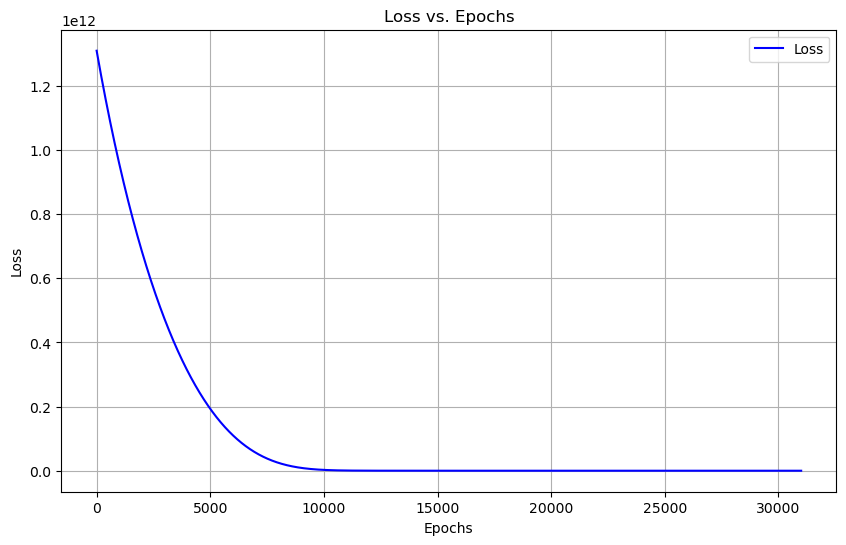

In [8]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, Losses, label='Loss', color='blue')  # Plot Losses vs. epochs
plt.title('Loss vs. Epochs')  # Title of the plot
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Show grid lines for better readability
plt.show()

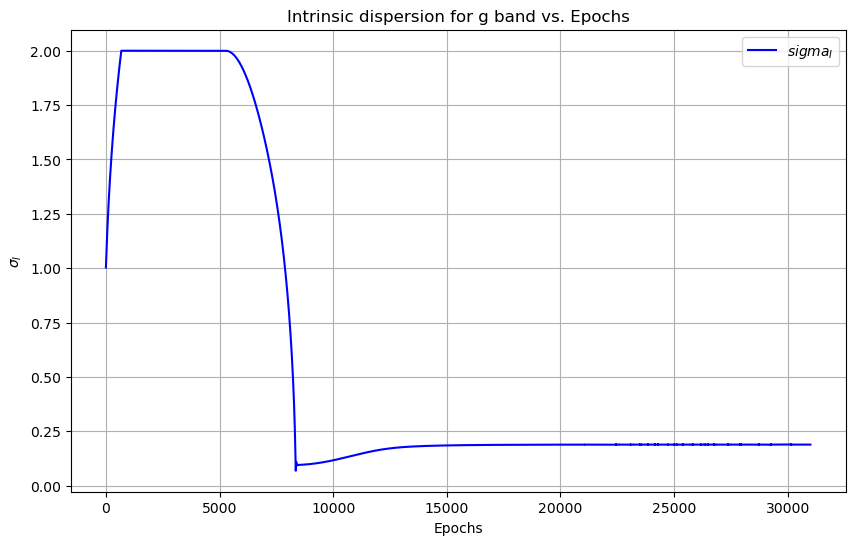

In [9]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, param0_values, label='$sigma_I$', color='blue')  # Plot Losses vs. epochs
plt.title('Intrinsic dispersion for g band vs. Epochs')  # Title of the plot
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('$\sigma_I$')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Show grid lines for better readability
plt.show()

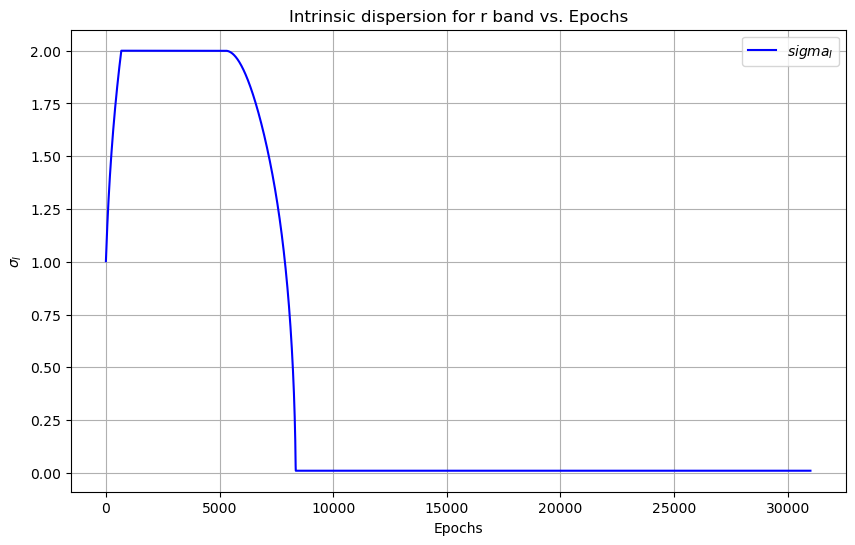

In [10]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, param2_values, label='$sigma_I$', color='blue')  # Plot Losses vs. epochs
plt.title('Intrinsic dispersion for r band vs. Epochs')  # Title of the plot
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('$\sigma_I$')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Show grid lines for better readability
plt.show()

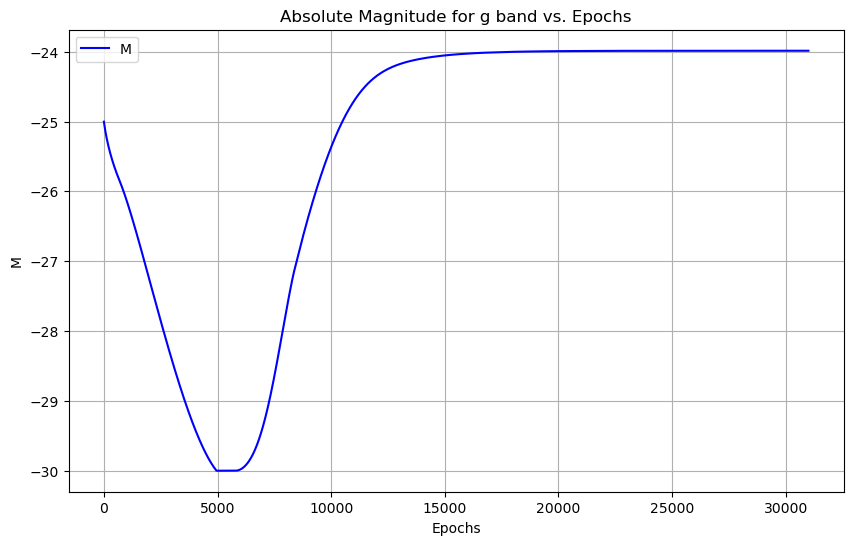

In [11]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, param1_values, label='M', color='blue')  # Plot Losses vs. epochs
plt.title('Absolute Magnitude for g band vs. Epochs')  # Title of the plot
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('M')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Show grid lines for better readability
plt.show()

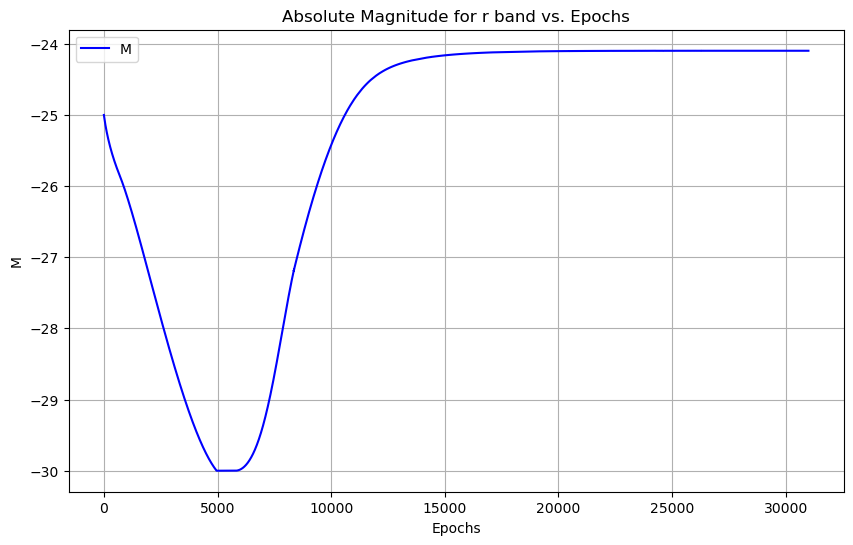

In [12]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, param3_values, label='M', color='blue')  # Plot Losses vs. epochs
plt.title('Absolute Magnitude for r band vs. Epochs')  # Title of the plot
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('M')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Show grid lines for better readability
plt.show()

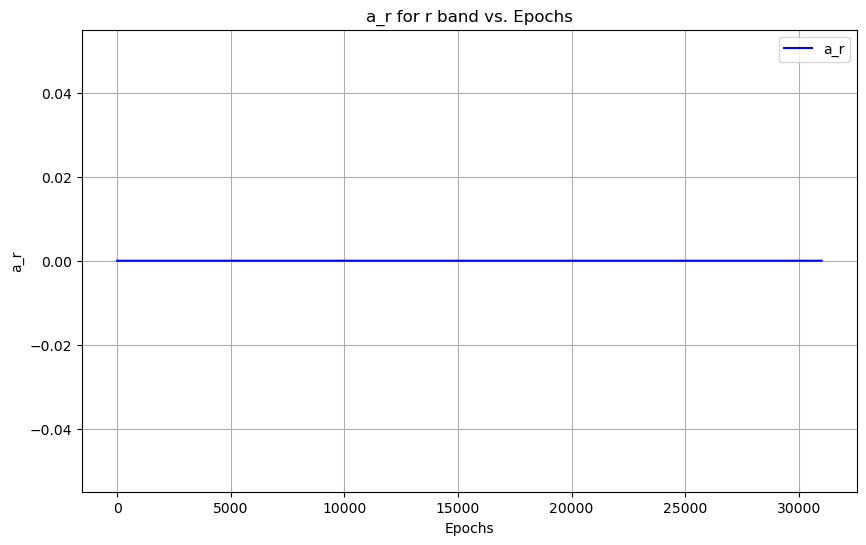

In [13]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, param4_values, label='a_r', color='blue')  # Plot Losses vs. epochs
plt.title('a_r for r band vs. Epochs')  # Title of the plot
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('a_r')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Show grid lines for better readability
plt.show()

In [14]:
# Access optimized parameters
optimized_params = params.data

# If you need to convert to a numpy array for further processing outside PyTorch
optimized_params_numpy = optimized_params.numpy()

print("Optimized Parameters:", optimized_params)
print("As Numpy Array:", optimized_params_numpy)

Optimized Parameters: tensor([ 1.8890e-01, -2.3986e+01,  1.0000e-02,  ...,  1.9492e-01,
        -6.8989e-02, -9.8945e-01])
As Numpy Array: [ 1.8889599e-01 -2.3986448e+01  9.9999998e-03 ...  1.9492367e-01
 -6.8988696e-02 -9.8945284e-01]


(array([  3.,   0.,   3.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,
          0.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,
          0.,   0.,   4.,   0.,   2.,   4.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   3.,   2.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,
          4.,   3.,   0.,   2.,   0.,   0.,   2.,   0.,   0.,   4.,   0.,
          2.,   0.,  10.,   0.,   3.,   0.,   2.,   4.,   0.,   0.,   0.,
          0.,   6.,   3.,   0.,   0.,   0.,   2.,   3.,   2.,   3.,   2.,
          0.,   0.,   2.,   2.,   0.,   5.,   2.,   0.,   0.,   0.,   2.,
          0.,   2.,   4.,   5.,   0.,   3.,   5.,   5.,   7.,   2.,   0.,
          5.,   2.,   5.,   4.,   9.,   0.,   5.,   0.,   5.,   5.,   2.,
          2.,   0.,   5.,   5.,   5.,   3.,   0.,   7.,   7.,   3.,   3.,
          3.,   2.,   2.,   5.,   4., 

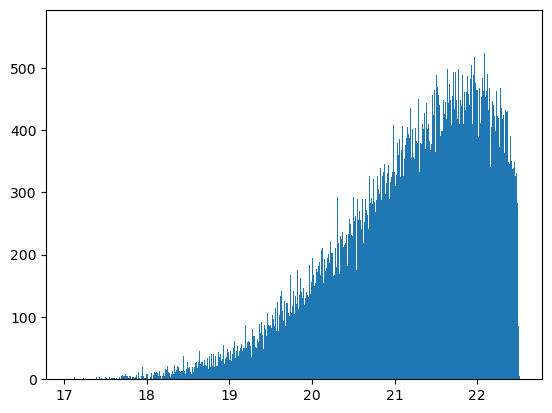

In [16]:
plt.hist(optimized_params_numpy[5:apr_mag_g_tensor.shape[0]+5],bins=1000)

(array([  3.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,   3.,
          0.,   4.,   0.,   2.,   0.,   2.,   0.,   0.,   3.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   3.,   0.,   3.,
          0.,   2.,   2.,   0.,   0.,   3.,   5.,   0.,   2.,   0.,   3.,
          0.,   0.,   2.,   2.,   0.,   0.,   0.,   0.,   6.,   5.,   0.,
          2.,   0.,   4.,   0.,   0.,   4.,   0.,   0.,   0.,   3.,   2.,
          4.,   5.,   0.,   0.,   2.,   2.,   2.,   4.,   4.,   0.,   4.,
          2.,   0.,   2.,   4.,   2.,   0.,   2.,   3.,   5.,   3.,   0.,
          3.,   5.,   4.,   3.,   0.,   2.,   2.,   2.,   5.,   0.,   2.,
          3.,   9.,   5.,   5.,   0.,   5.,   0.,   9.,   0.,   0.,   5.,
          0.,   4.,  13.,   8.,   2., 

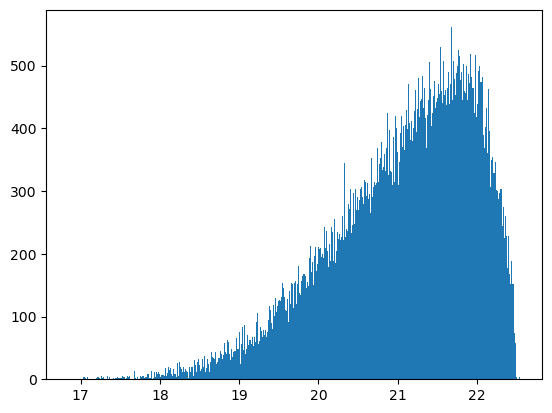

In [18]:
plt.hist(optimized_params_numpy[apr_mag_g_tensor.shape[0]+5:2*apr_mag_g_tensor.shape[0]+5],bins=1000)

(array([  7.,   0.,   3.,   0.,   0.,   4.,   5.,   3.,   5.,  10.,  17.,
         14.,  10.,  13.,  16.,  27.,  32.,  49.,  35.,  22.,  42.,  37.,
         28.,  24.,  54.,  52.,  47.,  53.,  64.,  89.,  69.,  77.,  75.,
         35.,  87.,  69.,  89.,  95.,  93., 103., 121., 131., 119., 136.,
        167., 154., 124., 202., 146., 148., 154., 151., 189., 174., 184.,
        215., 184., 182., 180., 187., 234., 222., 194., 258., 220., 246.,
        235., 270., 238., 250., 220., 245., 285., 258., 281., 228., 306.,
        236., 242., 274., 314., 363., 306., 301., 335., 338., 333., 296.,
        255., 278., 260., 322., 348., 311., 349., 354., 324., 335., 327.,
        311., 392., 306., 345., 317., 377., 377., 372., 424., 369., 377.,
        355., 379., 300., 438., 402., 448., 354., 429., 417., 392., 366.,
        448., 428., 403., 396., 420., 461., 411., 447., 433., 423., 391.,
        427., 416., 446., 433., 381., 424., 464., 392., 425., 476., 464.,
        422., 471., 431., 441., 426., 

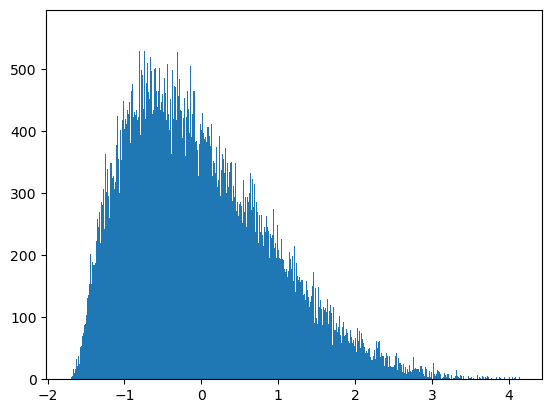

In [19]:
plt.hist(optimized_params_numpy[subset_start_g:subset_end_g],bins=1000)